# Attention mechanism for sentiment analysis

In this lab we use part of the 'Amazon_Unlocked_Mobile.csv' dataset published by Kaggle. The dataset contain the following information:
* Product Name
* Brand Name
* Price
* Rating
* Reviews
* Review Votes

We are mainly interested by the 'Reviews' (X) and by the 'Rating' (y)


The goal is to try to predict the 'Rating' after reading the 'Reviews'. I've prepared for you TRAIN and TEST set.
The work to be done is as follows:

1. Feature extraction and baseline
    * read the dataset and understand it
    * put it in a format so that you can use `CountVectorizer` or`Tf-IDF` to extract the desired features
    * perform on the desired dates and preprocessing
    * use one of the classifiers you know to predict the polarity of different sentences
1. My first neural network
    * reuse the features already extracted 
    * proposed a neural network built with Keras
1. Hyper-parameter fitting
    * for the base line: adjust min_df, max_df, ngram, max_features + model's hyper-parameter
    * for the neural network: adjust batch size, number of layers and number of neuron by layers, use earlystop
1. <span style="color:red">Word embedding
    * stage 1 build a network that uses Keras' embedding which is not language sensitive.
    * stage 2 build a network that simultaneously uses Keras' embedding and the features extracted in the first weeks.
    * stage 3 try to use an existing embedding (https://github.com/facebookresearch/MUSE)
    </span>

**WARNING:** the dataset is voluminous, I can only encourage you to work first on a small part of it and only at the end, when the code is well debugged and that it is necessary to build the "final model", to use the whole dataset.

In [1]:
"""
(Practical tip) Table of contents can be compiled directly in jupyter notebooks using the following code:
I set an exception: if the package is in your installation you can import it otherwise you download it 
then import it.
"""
try:
    from jyquickhelper import add_notebook_menu 
except:
    !pip install jyquickhelper
    from jyquickhelper import add_notebook_menu
    
"""
Output Table of contents to navigate easily in the notebook. 
For interested readers, the package also includes Ipython magic commands to go back to this cell
wherever you are in the notebook to look for cells faster
"""
add_notebook_menu()

## Imports

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from sklearn.preprocessing import OneHotEncoder

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, TextVectorization, Embedding, Dense, Dropout, Activation
from tensorflow.keras.layers import TimeDistributed, LSTM
from tensorflow.keras.layers import Flatten, RepeatVector, Dot, Permute, AveragePooling1D
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, LSTM, Bidirectional, AveragePooling1D, RepeatVector
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

In [5]:
import tensorflow_addons as tfa
from tensorflow_addons.metrics import F1Score

## Read the dataset

Could you find below a proposal. You can complete them.

In [6]:
TRAIN = pd.read_csv("http://www.i3s.unice.fr/~riveill/dataset/Amazon_Unlocked_Mobile/train.csv.gz").fillna(value="")
VAL = pd.read_csv("http://www.i3s.unice.fr/~riveill/dataset/Amazon_Unlocked_Mobile/val.csv.gz").fillna(value="")
TEST = pd.read_csv("http://www.i3s.unice.fr/~riveill/dataset/Amazon_Unlocked_Mobile/test.csv.gz").fillna(value="")

TRAIN.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,Samsung Galaxy Note 4 N910C Unlocked Cellphone...,Samsung,449.99,4,I love it!!! I absolutely love it!! 👌👍,0.0
1,BLU Energy X Plus Smartphone - With 4000 mAh S...,BLU,139.0,5,I love the BLU phones! This is my second one t...,4.0
2,Apple iPhone 6 128GB Silver AT&T,Apple,599.95,5,Great phone,1.0
3,BLU Advance 4.0L Unlocked Smartphone -US GSM -...,BLU,51.99,4,Very happy with the performance. The apps work...,2.0
4,Huawei P8 Lite US Version- 5 Unlocked Android ...,Huawei,198.99,5,Easy to use great price,0.0


In [7]:
''' Construct X_train and y_train '''
X_train = np.array(TRAIN['Reviews']).reshape(-1,1)

ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
y_train = ohe.fit_transform(np.array(TRAIN['Rating']).reshape(-1,1))

X_train.shape, y_train.shape

((5000, 1), (5000, 5))

In [8]:
''' Do the same for val '''
X_val = np.array(VAL['Reviews']).reshape(-1,1)
y_val = ohe.transform(np.array(VAL['Rating']).reshape(-1,1))

''' Do the same for test '''
X_test = np.array(TEST['Reviews']).reshape(-1,1)
y_test = ohe.transform(np.array(TEST['Rating']).reshape(-1,1))

## Build an a neural network with vectorized embedding and RNN cells.

The task is to predict the sentiment according to the content of the review. We can treat this kind of task by a Many-to-one model.

![LSTM for sentiment analysis](https://www.programmerall.com/images/679/8c/8c66e6ee3b9418358a791b363572bedf.jpeg)

Implement such a network with :
- a first layer of type LSTM
- a second layer of type LSTM, each cell of this layer will be fed by the corresponding output of the first layer (see figure above).



In [9]:
# Constants
## Part one 
nb_classes = y_train.shape[1]
vocab_size = 2000    # Maximum vocab size -- adjust with the size of the vocabulary 2000 is a good metric since the voc size is 13000
embedding_size = 300 # Embedding size - increase it to 300
recurrent_size = 64 # Recurrent size - keep ot
hidden_size = recurrent_size//4    # Hidden layer
dropout_rate = 0.2   # Dropout rate for regularization # usually 0.2 is the best
max_len = 100         # Sequence length to pad the outputs to -- adjust with the distribution of the reviews length
learning_rate=0.00001 # decrease it takes more time and lead to heavy calculation but ensure to get good results.

In [10]:
# Create the vectorized layer.
vectorize_layer = TextVectorization(max_tokens=vocab_size,
                                    standardize="lower_and_strip_punctuation",
                                    # it is possible to build your own function
                                    # to transform emoji into text
                                    # to transform foreign reviews in english one
                                    # etc.
                                    output_mode='int',
                                    output_sequence_length=max_len)

In [11]:
# Fit vectorized layer on train
vectorize_layer.adapt(X_train)

In [12]:
# Define the network
def build_model():
    input_ = Input(shape=(1,), dtype=tf.string)
    x = vectorize_layer(input_)
    x = Embedding(vocab_size, embedding_size, name="Embedding")(x)
    x = LSTM(recurrent_size, return_sequences=False,
             dropout=dropout_rate, recurrent_dropout=dropout_rate)(x)
    x = Dense(hidden_size, activation="relu")(x)
    x = Dropout(dropout_rate)(x)
    output_ = Dense(nb_classes, activation='softmax', dtype=tf.float64)(x)
    model = Model(input_, output_)
    return model

model = build_model()

In [13]:
# summarize the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 100)              0         
 torization)                                                     
                                                                 
 Embedding (Embedding)       (None, 100, 300)          600000    
                                                                 
 lstm (LSTM)                 (None, 64)                93440     
                                                                 
 dense (Dense)               (None, 16)                1040      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                             

In [14]:
plot_model(model, show_shapes=True, show_layer_names=True, to_file='LSTM.png')

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [15]:
# Compile the model
f1 = F1Score(num_classes=nb_classes, average="macro", threshold=None)
op = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer=op, loss='categorical_crossentropy', metrics=[f1])

In [16]:
# fit model using ealy stopping
es = EarlyStopping(monitor='val_f1_score', mode='max', patience=10, restore_best_weights=True, verbose=1)
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val), 
                    epochs=4000, callbacks=[es], verbose=1)

Epoch 1/4000
157/157 [==============================] - 12s 64ms/step - loss: 1.5714 - f1_score: 0.1911 - val_loss: 1.5422 - val_f1_score: 0.1586
Epoch 2/4000
157/157 [==============================] - 9s 56ms/step - loss: 1.5210 - f1_score: 0.1741 - val_loss: 1.4825 - val_f1_score: 0.1484
Epoch 3/4000
157/157 [==============================] - 9s 57ms/step - loss: 1.4551 - f1_score: 0.1653 - val_loss: 1.3975 - val_f1_score: 0.1436
Epoch 4/4000
157/157 [==============================] - 9s 56ms/step - loss: 1.3751 - f1_score: 0.1557 - val_loss: 1.3156 - val_f1_score: 0.1433
Epoch 5/4000
157/157 [==============================] - 9s 56ms/step - loss: 1.3433 - f1_score: 0.1518 - val_loss: 1.2921 - val_f1_score: 0.1434
Epoch 6/4000
157/157 [==============================] - 9s 56ms/step - loss: 1.3348 - f1_score: 0.1469 - val_loss: 1.2858 - val_f1_score: 0.1434
Epoch 7/4000
157/157 [==============================] - 9s 56ms/step - loss: 1.3301 - f1_score: 0.1453 - val_loss: 1.2812 - val_f

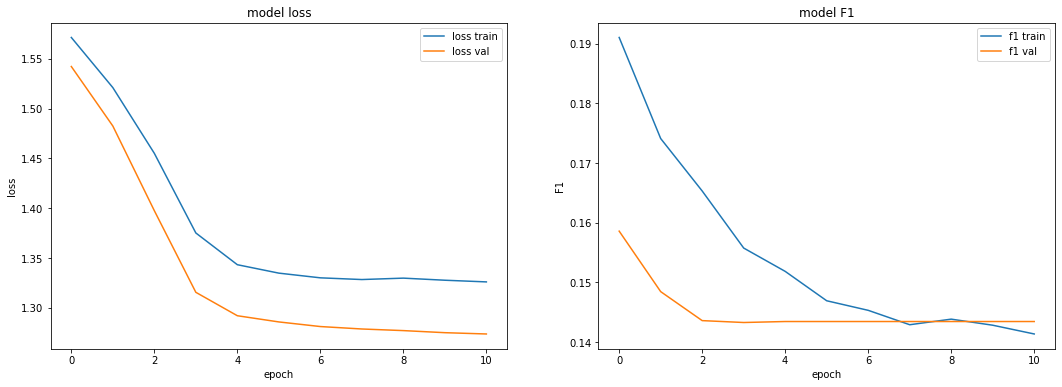

In [17]:
# plot history
def babysit(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))

    # summarize history for loss
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])
    ax1.set_title('model loss')
    ax1.set_ylabel('loss')
    ax1.set_xlabel('epoch')
    ax1.legend(['loss train', 'loss val'], loc='best')

    # summarize history for loss
    ax2.plot(history.history['f1_score'])
    ax2.plot(history.history['val_f1_score'])
    ax2.set_title('model F1')
    ax2.set_ylabel('F1')
    ax2.set_xlabel('epoch')
    ax2.legend(['f1 train', 'f1 val'], loc='best')

    plt.show()
    
babysit(history)

In [18]:
# Evaluate the model
f1.update_state(y_test, model.predict(X_test))
print('F1: %f' % (f1.result().numpy()))

F1: 0.154452


<font color='red'>
$To\ do\ student$

1. Understand the code
1. Play with LSTM model for sentiment analysis
    * Replace LSTM by BI-LSTM
    * Use stacked LSTM or BI-LSTM
    * Use all hidden state and average it
</font>

<font color='green'>
$If\ you\ want\ to\ go\ further$

If you are interested in the subject, current networks for sentiment prediction combine a part with recurrent networks (LTSM) to capture long dependencies and a part with convolution (CNN) to capture short dependencies. [This resarch paper](https://arxiv.org/pdf/1904.04206.pdf) or [this one](https://hal.archives-ouvertes.fr/hal-03052803/document) describe some accurate networks for sentiment analysis.

Here, another paper that gives you some indications to go further: [Attention, CNN and what not for Text Classification](https://mlwhiz.com/blog/2019/03/09/deeplearning_architectures_text_classification/)

You will see next week the CNN with Diane. So there is no need to use them today.
</font>

## Attention with LSTM network



In [19]:
# ------------------------------------------------------
# MODEL BUILDING
# ------------------------------------------------------
def build_model():
    # Input: a review
    input_ = Input(shape=(1, ), name="input", dtype=tf.string)

    # Transform the review in a list of tokenID
    vect = vectorize_layer(input_)

    # Keras embedding
    embedding = Embedding(vocab_size,
                          embedding_size, 
                          weights=None,  # Without pre-learning
                          trainable=True,# Trainable
                          name='embedding'
                         )(vect)
    
    # You can try also a Bidirectionnel cell
    rnn = LSTM(recurrent_size, return_sequences=True, 
               return_state=False,
               dropout=dropout_rate, recurrent_dropout=dropout_rate)(embedding)
    
    # In the case of LSTM, there are two internal states
    #      the hidden state, usually denoted by h,
    #      the cell state usually denoted by c
    # The tuple (c, h) is the internal state of a LSTM
    # return_sequences=True gives you the hidden state (h) of the LSTM for every timestep
    # used in combination with return_state=True, you will only get the tuple (c, h) for the final timestep

    # Attention layer
    attention = Dense(1, activation='tanh')(rnn)
    attention = Flatten()(attention)
    attention = Activation('softmax')(attention)
  

    # Pour pouvoir faire la multiplication (scalair/vecteur KERAS)
    attention = RepeatVector(recurrent_size)(attention) # NORMAL RNN
    attention = Permute([2, 1])(attention)
  
    # Application de l'attention sur la sortie du RNN
    sent_representation = Dot(axes=1, normalize=False)([rnn, attention])
    
    # Flatten pour entrer dans le Dense
    flatten = Flatten()(sent_representation)
    
    # Dense pour la classification avec 1 couche cachee
    hidden_dense = Dense(hidden_size, activation="relu")(flatten)
    hidden_dense = Dropout(dropout_rate)(hidden_dense)

    # Classification et ouput
    output_ = Dense(nb_classes, activation='softmax')(hidden_dense)
    
    # Build  model
    model = Model(inputs=input_, outputs=output_)
    
    return model

model = build_model()

In [20]:
# Plot model
# !pip install pydot
plot_model(model, show_shapes=True, show_layer_names=True, to_file='LSTM_with_attention.png')

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [21]:
# Compile the model
f1 = F1Score(num_classes=nb_classes, average="macro", threshold=0.5)
op = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer=op, loss='categorical_crossentropy', metrics=[f1])

In [22]:
# fit model using ealy stopping
es = EarlyStopping(monitor='val_f1_score', mode='max', patience=5, restore_best_weights=True, verbose=2)
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val), 
                    epochs=4000, callbacks=[es], verbose=1)

Epoch 1/4000
157/157 [==============================] - 12s 64ms/step - loss: 1.5760 - f1_score: 0.0000e+00 - val_loss: 1.5123 - val_f1_score: 0.0000e+00
Epoch 2/4000
157/157 [==============================] - 9s 60ms/step - loss: 1.4349 - f1_score: 0.0181 - val_loss: 1.2934 - val_f1_score: 0.0000e+00
Epoch 3/4000
157/157 [==============================] - 9s 60ms/step - loss: 1.3173 - f1_score: 0.1236 - val_loss: 1.2466 - val_f1_score: 0.1357
Epoch 4/4000
157/157 [==============================] - 9s 60ms/step - loss: 1.3117 - f1_score: 0.1242 - val_loss: 1.2445 - val_f1_score: 0.1354
Epoch 5/4000
157/157 [==============================] - 9s 60ms/step - loss: 1.3113 - f1_score: 0.1238 - val_loss: 1.2396 - val_f1_score: 0.1363
Epoch 6/4000
157/157 [==============================] - 9s 60ms/step - loss: 1.3126 - f1_score: 0.1218 - val_loss: 1.2398 - val_f1_score: 0.1361
Epoch 7/4000
157/157 [==============================] - 9s 60ms/step - loss: 1.3045 - f1_score: 0.1214 - val_loss: 1.

157/157 [==============================] - 9s 59ms/step - loss: 0.9094 - f1_score: 0.2986 - val_loss: 0.8752 - val_f1_score: 0.2856
Epoch 58/4000
157/157 [==============================] - 9s 59ms/step - loss: 0.9126 - f1_score: 0.2970 - val_loss: 0.8836 - val_f1_score: 0.2794
Epoch 59/4000
157/157 [==============================] - 9s 60ms/step - loss: 0.9060 - f1_score: 0.2975 - val_loss: 0.8757 - val_f1_score: 0.2880
Epoch 60/4000
157/157 [==============================] - 9s 60ms/step - loss: 0.8993 - f1_score: 0.3025 - val_loss: 0.8755 - val_f1_score: 0.2893
Epoch 61/4000
157/157 [==============================] - 9s 59ms/step - loss: 0.9111 - f1_score: 0.3007 - val_loss: 0.8784 - val_f1_score: 0.2863
Epoch 62/4000
157/157 [==============================] - 9s 59ms/step - loss: 0.8881 - f1_score: 0.3034 - val_loss: 0.8755 - val_f1_score: 0.2895
Epoch 63/4000
157/157 [==============================] - 9s 59ms/step - loss: 0.8870 - f1_score: 0.3064 - val_loss: 0.8768 - val_f1_score:

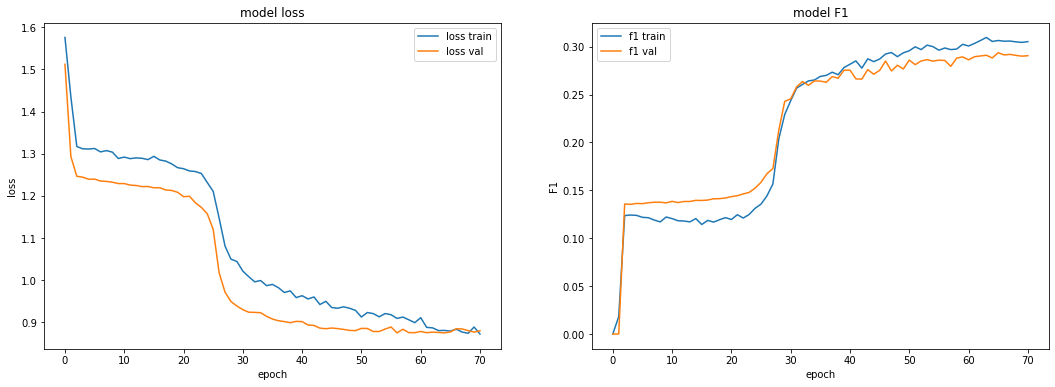

In [23]:
# plot history
babysit(history)

In [24]:
# Evaluate the model
f1.update_state(y_test, model.predict(X_test))
print('F1: %f' % (f1.result().numpy()))

F1: 0.292074


## Use Attentionnal model

In [25]:
# ------------------------------------------------------
# GET ATTENTION MODEL
# ------------------------------------------------------
def get_attention_model(model):
    attention_layer_indice = 0
    for layer in model.layers:
        print(type(layer))
        if type(layer) is Activation:
            break
        else:
            attention_layer_indice += 1

    # Create an attention model
    return Model(inputs=model.layers[0].input, outputs=model.layers[attention_layer_indice].output)

In [26]:
# PLOT ATTENTION MODEL from classifier model with ATTENTION
attention_model = get_attention_model(model)
plot_model(attention_model, show_shapes=True, show_layer_names=True, to_file='model_get_attention.png')

<class 'keras.engine.input_layer.InputLayer'>
<class 'keras.layers.preprocessing.text_vectorization.TextVectorization'>
<class 'keras.layers.embeddings.Embedding'>
<class 'keras.layers.recurrent_v2.LSTM'>
<class 'keras.layers.core.dense.Dense'>
<class 'keras.layers.core.flatten.Flatten'>
<class 'keras.layers.core.activation.Activation'>
('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [27]:
# ------------------------------------------------------
# GET ATTENTION
# ------------------------------------------------------
attentions = attention_model.predict(X_val[0])
attentions

array([[0.01671109, 0.01697292, 0.01591383, 0.01501828, 0.0142739 ,
        0.01365849, 0.01315092, 0.01273246, 0.01238716, 0.01210174,
        0.01186523, 0.01166867, 0.01150467, 0.0113672 , 0.01125134,
        0.01115301, 0.01106887, 0.01099618, 0.01093269, 0.01087652,
        0.01082615, 0.01078032, 0.010738  , 0.01069834, 0.01066064,
        0.01062435, 0.010589  , 0.01055421, 0.01051968, 0.01048515,
        0.01045044, 0.01041537, 0.01037981, 0.01034365, 0.01030682,
        0.01026923, 0.01023085, 0.01019164, 0.01015155, 0.01011059,
        0.01006874, 0.010026  , 0.00998238, 0.00993791, 0.00989261,
        0.00984653, 0.00979969, 0.00975217, 0.00970403, 0.00965534,
        0.00960619, 0.00955667, 0.00950688, 0.00945694, 0.00940696,
        0.00935707, 0.0093074 , 0.0092581 , 0.0092093 , 0.00916114,
        0.00911376, 0.00906731, 0.00902191, 0.00897771, 0.0089348 ,
        0.00889332, 0.00885334, 0.00881496, 0.00877823, 0.00874322,
        0.00870996, 0.00867846, 0.00864874, 0.00

In [28]:
# ------------------------------------------------------
# GET ATTENTION for each WORD
# ------------------------------------------------------
from sklearn import preprocessing

def get_attention(X, y, prediction, attention, N=5):
    # normalize attention (without the padding part)
    normalized_attention = preprocessing.QuantileTransformer().fit_transform(attention)
  
    results = []
    for i, (X_, y_, p_, a_) in enumerate(zip(X, y, prediction, normalized_attention)):
        if i>N:
            break
        # build result
        result_entry = {}
        result_entry["prediction"] = (np.argmax(y_), np.argmax(p_))
        result_entry["original"] = np.asscalar(X_)
        result_entry["sentence"] = []
        for j, word in enumerate(vectorize_layer(X_).numpy().flatten().tolist()):
            word_obj = {}
            if word==0:
                break
            word_obj[vectorize_layer.get_vocabulary()[word]] = a_[j].item()
            result_entry["sentence"].append(word_obj)
            
        results += [result_entry]
    return results

sentences_with_attention = get_attention(X_val, y_val,
                                         model.predict(X_val),
                                         attention_model.predict(X_val),
                                         10)   
sentences_with_attention[0]

C:\Users\hadik\AppData\Local\Temp/ipykernel_9740/2036900014.py:17: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  result_entry["original"] = np.asscalar(X_)


{'prediction': (0, 4),
 'original': 'Pretty good',
 'sentence': [{'pretty': 0.8423423171043396}, {'good': 0.9214214086532593}]}

In [29]:
# convert prediction with attention to colored text
from termcolor import colored

def print_text(sentences_with_attention):
    threshold=0.75
    classes=[]
    print(colored("In green, the most important word\n\n", 'green', attrs=['bold']))

    for i, sentence in enumerate(sentences_with_attention):
        # Retrieve the class of this sentence
        #print(sentence)
        original_class, predicted_class = sentence['prediction']
        #print(original_class, predicted_class)
    
        # Retrieve all the words and weights of this sentence
        words, weights = [], []
        #print("--", sentence['sentence'])
        for item in sentence['sentence']:
            for word, weight in item.items():
                words.append(word)
                weights.append(float(weight))
            
        size=0
        print(sentence['original'])
        for j, word in enumerate(words):
            if size!=0 and j!=0 and word!=',' and word!=".":
                print(' ', end="")
            if weights[j]>threshold:
                print(colored(word, 'green', attrs=['bold']), end=" ")
            elif weights[j] < (1-threshold):
                print(colored(word, 'red', attrs=['bold']), end=" ")
            else:
                print(colored(word, 'grey'), end=" ")
            size += len(word)+1
            if size>80:
                print()
            size=0
      
        print("\n")
    
print_text(sentences_with_attention)

In green, the most important word


Pretty good
pretty good 

Excellent,very good Very fast
[UNK] good very fast 

This was a replacement. We had a POS Samsung from Cincinnati Bell. That phone was the worst thing we ever owned! This HTC seems to be built to last. It is small. Dont plan on rocking a lot of video. However, it is an Andriod and I think my wife likes it. It feels sturdy too. We bought it unlocked. All we had to do was insert the SIM card. It took about 2min to get it all set up. Very nice! I would give it 4-stars but the internal memory will eventually be an issue.
this was a replacement we had a [UNK] samsung from [UNK] [UNK] that phone was the worst thing we ever owned this htc seems to be built to last it is small dont plan on [UNK] a lot of video however it is an [UNK] and i think my wife likes it it feels sturdy too we bought it unlocked all we had to do was insert the sim card it took about [UNK] to get it all set up very nice i would give it [UNK] but the internal m

## Your work

<font color='red'>
<br>
**$TO\ DO\ Students$**
    
1. Before modifying the code, take the time to understand it well. We use here the global attentions mechanism only from an encoder since the network for sentiment analysis has no decoder part, only a classifier 1
    
1. Improve the f1 score for the **Attentional LSTM** model using BI-LSTM approach, better hyper-parameters and a better preprocessing (the same as in the previous step).
    * Take inspiration from the course slides to build an original architecture that you will describe
    * Use your Attention part in order to explain the words taken into account by the network to predict the sentiment.
    
1. **Upload on moodle**
    * **a clean, documented notebook** containing **your best LSTM attentional model**. The evaluation metric is the f1 score (macro avg).
    * You can build all sorts of architectures but only using the cells seen in class (i.e. in particular: **CNNs are not yet seen so you should not use them**). 

    * It is of course possible / desirable to use keras tuner to get the best hyper-parameters.

    * This notebook will be evaluated and the grade will take into account the editorial quality of your text. 

    * Any notebook containing more than 1 model will not be evaluated (score = 0 -> **You have to choose the best one**).   
</font>

<font color='red'>



In [35]:
# ------------------------------------------------------
# MODEL BUILDING
# ------------------------------------------------------
def build_model():
    # Input: a review
    input_ = Input(shape=(1, ), name="input", dtype=tf.string)

    # Transform the review in a list of tokenID
    vect = vectorize_layer(input_)

    # Keras embedding
    embedding = Embedding(vocab_size,
                          embedding_size, 
                          weights=None,  # Without pre-learning
                          trainable=True,# Trainable
                          name='embedding'
                         )(vect)
    
    # You can try also a Bidirectionnel cell
    rnn1 = Bidirectional(LSTM(recurrent_size, return_sequences=True, 
               return_state=False,
               dropout=dropout_rate, recurrent_dropout=dropout_rate))(embedding) # Add the first hidden layer using Biderectional cell
    rnn2 = Bidirectional(LSTM(recurrent_size, return_sequences=True, 
               return_state=False,
               dropout=dropout_rate, recurrent_dropout=dropout_rate))(rnn1) # Add the second hidden layer using Biderectional cell
    # In the case of LSTM, there are two internal states 
    #      the hidden state, usually denoted by h,
    #      the cell state usually denoted by c
    # The tuple (c, h) is the internal state of a LSTM
    # return_sequences=True gives you the hidden state (h) of the LSTM for every timestep
    # used in combination with return_state=True, you will only get the tuple (c, h) for the final timestep

    # Attention layer
    attention = Dense(1, activation='tanh')(rnn2) # dense hidden layer
    attention = Flatten()(attention)
    attention = Activation('softmax')(attention)
  

    # Pour pouvoir faire la multiplication (scalair/vecteur KERAS)
    attention = RepeatVector(recurrent_size)(attention) # NORMAL RNN
    attention = Permute([2, 1])(attention)
  
    # Application de l'attention sur la sortie du RNN
    sent_representation = Dot(axes=1, normalize=False)([rnn2, attention])
    
    # Flatten pour entrer dans le Dense
    flatten = Flatten()(sent_representation)
    
    # Dense pour la classification avec 1 couche cachee
    hidden_dense = Dense(hidden_size, activation="relu")(flatten)
    hidden_dense = Dropout(dropout_rate)(hidden_dense)

    # Classification et ouput
    output_ = Dense(nb_classes, activation='softmax')(hidden_dense)
    
    # Build  model
    model = Model(inputs=input_, outputs=output_)
    
    return model

model = build_model()

In [36]:
# Compile the model
f1 = F1Score(num_classes=nb_classes, average="macro", threshold=0.5)
op = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer=op, loss='categorical_crossentropy', metrics=[f1]) # compile with f1 score

In [37]:
# fit model using ealy stopping
es = EarlyStopping(monitor='val_f1_score', mode='max', patience=10, restore_best_weights=True, verbose=2)
# fit the model
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val), 
                    epochs=4000, callbacks=[es], verbose=1)

Epoch 1/4000
157/157 [==============================] - 53s 300ms/step - loss: 1.5369 - f1_score: 0.0000e+00 - val_loss: 1.4183 - val_f1_score: 0.0000e+00
Epoch 2/4000
157/157 [==============================] - 45s 287ms/step - loss: 1.3574 - f1_score: 0.0896 - val_loss: 1.2558 - val_f1_score: 0.1358
Epoch 3/4000
157/157 [==============================] - 46s 294ms/step - loss: 1.3307 - f1_score: 0.1146 - val_loss: 1.2511 - val_f1_score: 0.1350
Epoch 4/4000
157/157 [==============================] - 46s 294ms/step - loss: 1.3179 - f1_score: 0.1147 - val_loss: 1.2492 - val_f1_score: 0.1351
Epoch 5/4000
157/157 [==============================] - 46s 294ms/step - loss: 1.3173 - f1_score: 0.1130 - val_loss: 1.2477 - val_f1_score: 0.1351
Epoch 6/4000
157/157 [==============================] - 46s 295ms/step - loss: 1.3128 - f1_score: 0.1153 - val_loss: 1.2420 - val_f1_score: 0.1358
Epoch 7/4000
157/157 [==============================] - 46s 295ms/step - loss: 1.3088 - f1_score: 0.1146 - val

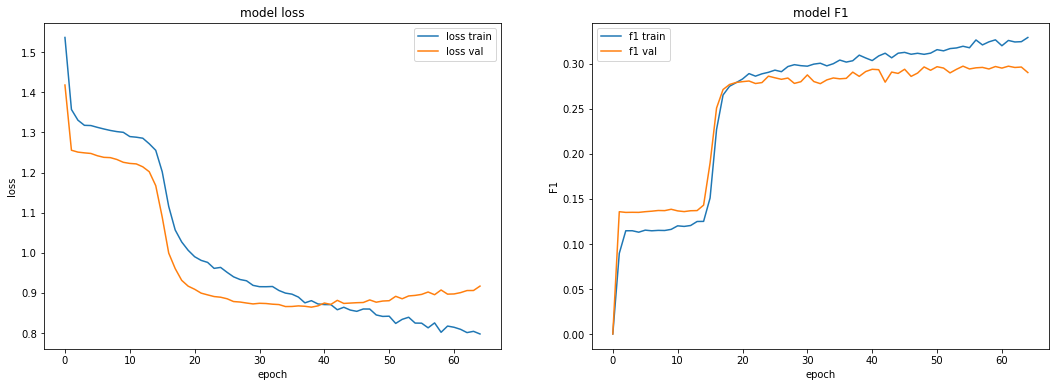

In [38]:
# plot history
babysit(history)

In [39]:
# Evaluate the model
f1.update_state(y_test, model.predict(X_test))
print('F1: %f' % (f1.result().numpy()))

F1: 0.295344


In [ ]:
# The best model is when I used biderectional layers, with vocab size of 2000 and learning rate of 0.00001. It is clear that 
# the biderectional improve the model metrics.